## In Jupyter Notebook run first

In [6]:
%reload_ext autoreload
%run -i C:/Users/champ/Python_proj/base_financial_repo/Econometric_data_repo/meta_data/imports
%run -i C:/Users/champ/Python_proj/base_financial_repo/Econometric_data_repo/meta_data/API
%run -i C:/Users/champ/Python_proj/base_financial_repo/Econometric_data_repo/meta_data/global_vars_and_constants
%run -i C:/Users/champ/Python_proj/base_financial_repo/Econometric_data_repo/meta_data/functions

Ready to go !


# Main

Downloding financial data ....
xlp
xle
xlv
xli
xlb
xlk
iyt
xlu
vcr
vfh
vnq
tlt
spy
ivv
spxl
bnd
gld
Downloding financial data .... Finished
Today the market was open and the 
sectors price data is updated

Last run: 2020-08-10 13:50:37.927096
The last 20 years of price data
Market analysis end timestamp : 16

The ascending mean return for 1,3,6,12mo ranking for 11 sectors are :
Ticker  Av_ret            category  Div yeild / yr  Div - exp  Expense ratio   EX_date_x Future_EX_date  Days_left     reg_Vol
   xlk    23.6          Technology            1.15       1.02           0.13  2020-06-22     2020-10-11       62.0   8052633.0
   vcr    20.5   Consumer Cyclical            1.13       1.03           0.10  2020-06-22     2020-10-24       75.0     82432.0
   iyt    10.5         Industrials            1.63       1.21           0.42  2020-06-15     2020-09-25       46.0    221463.0
   xlb    10.0   Natural Resources            2.14       2.01           0.13  2020-06-22     2020-10-11       6

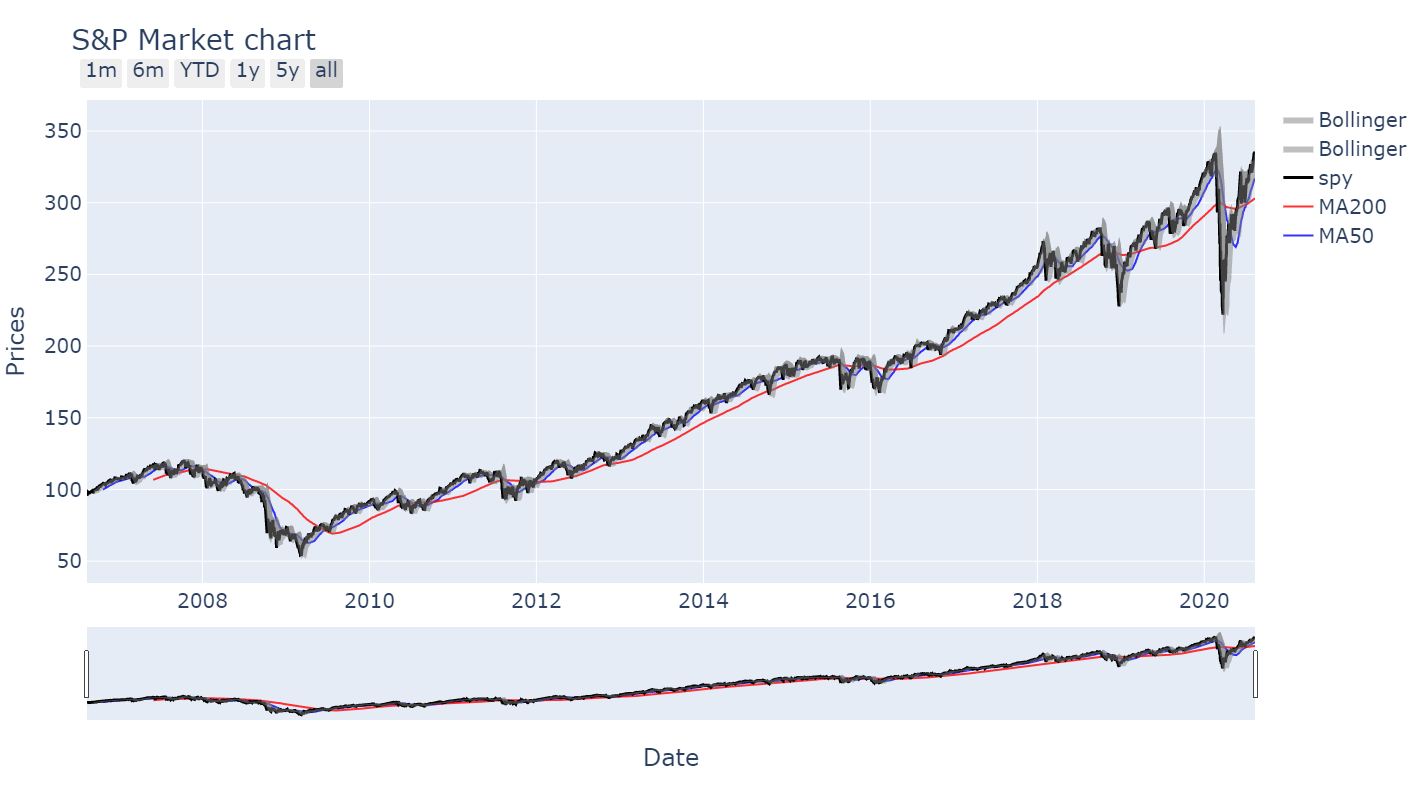

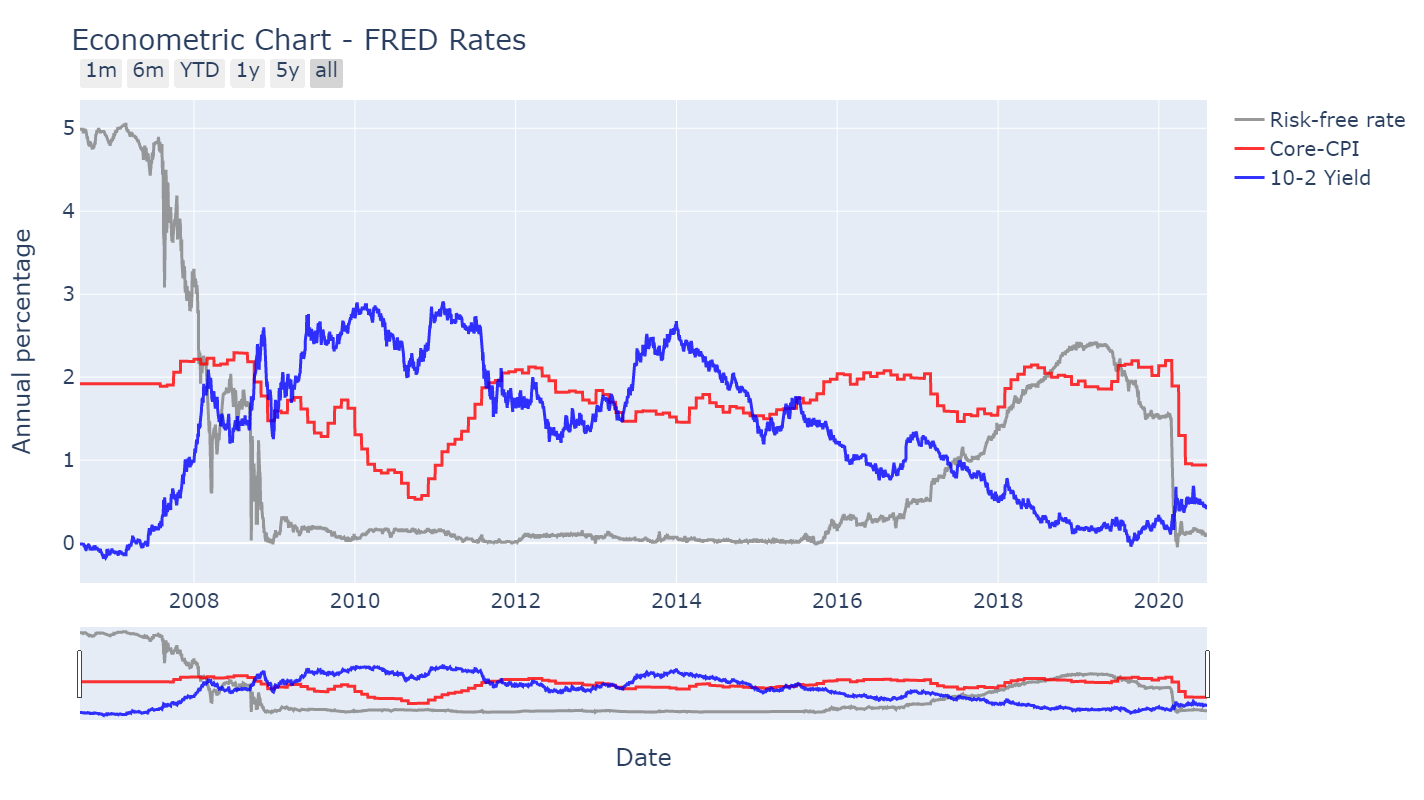

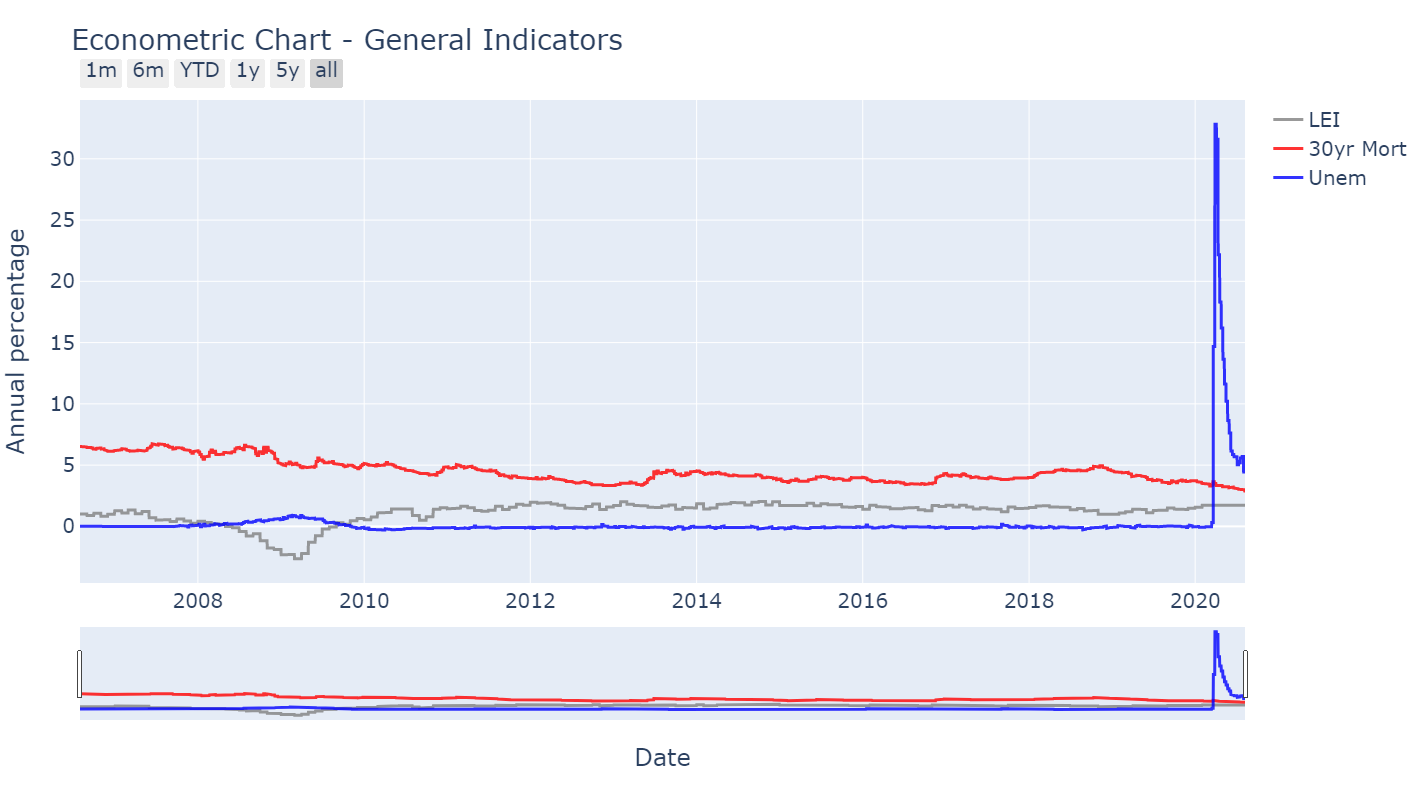

In [11]:

df_sec = update_securities_df(Securities_file_import_from_csv, update = True)

data_type='Adj Close'

df = df_sec
df = df.loc[(df['Type'] == 'sector') | (df['Type'] == 'inx')]
df = df['Ticker'].values.tolist()

sector_price_data = get_prices(df, account = SECURITY_ARRAY[0], 
                               FOLDER_LOCATION = META_FILE_FOLDER_LOCATION,
                               data_type = 'Adj Close', start_date = start_date, force_update = False)

    
inx_price_data = sector_price_data[[INX]].copy()
#inx_price_data = inx_price_data.rename(columns={inx_price_data[0]: INX })
inx_price_data['MA50_index']=inx_price_data[INX].rolling(50).mean()
inx_price_data['MA200_index']=inx_price_data[INX].rolling(200).mean()
#inx_price_data.index = pd.to_datetime(inx_price_data.index)

#  Function calls
Market_indicator_signal,mkt_ind = get_mkt_indicator(inx_price_data)
Average_return = _1_3_6_9_12_month_returns(sector_price_data)
FRED_data_mort = get_FRED_data('MORTGAGE30US','mort',start_date,0,1,FRED_API)
FRED_data_LEI = get_FRED_data('USSLIND','LEI',start_date,0,1,FRED_API)
FRED_data_inf = get_FRED_data('CPILFESL','inf',start_date,12,100,FRED_API)
FRED_data_10_2 = get_FRED_data('T10Y2Y','10_2',start_date,0,1,FRED_API)
FRED_data_RF = get_FRED_data('DTB3','RF',start_date,0,1,FRED_API)
FRED_data_ICSA = get_FRED_data('ICSA','UnEmp',start_date,52,1,FRED_API)

combined_12_mo_return = pd.concat([FRED_data_RF, FRED_data_inf,
                                  FRED_data_LEI, FRED_data_mort,
                                  FRED_data_10_2, FRED_data_ICSA], 
                                  axis=1, sort=False)

combined_12_mo_return = combined_12_mo_return.fillna(method='ffill')
combined_12_mo_return = combined_12_mo_return.fillna(method='bfill')

temp = bollinger_bands_graph(inx_price_data,INX);

#  Display
display = display_relative_strength(Average_return,
                                    Market_indicator_signal,
                                    mkt_ind,
                                    securities_file_location)

# S&P CHART
font = 1.0
inx_price_data = inx_price_data.reset_index()
Upper_bollinger = go.Scatter(x=inx_price_data['Date'],
                        y=inx_price_data['Upper Band'],
                                                     fill = "tonexty",
                        line=go.scatter.Line(color='gray', width = font*.0001),
                           opacity=0.8,
                           name='Bollinger',
                           text='Bollinger')

Lower_bollinger = go.Scatter(x=inx_price_data['Date'],
                        y=inx_price_data['Lower Band'],
                             fill = "tonexty",
                        line=go.scatter.Line(color='gray', width = font*.0001),
                           opacity=0.8,
                           name='Bollinger',
                           text='Bollinger')


price_data = go.Scatter(x=inx_price_data['Date'],
                        y=inx_price_data['spy'],
                        line=go.scatter.Line(color='black', width = font*3),
                           opacity=0.8,
                           name='spy',
                           text='price')

shrt_MA_data = go.Scatter(x=inx_price_data['Date'],
                        y=inx_price_data['MA50_index'],
                        line=go.scatter.Line(color='blue', width = font*2),
                           opacity=0.8,
                           name='MA50',
                           text='MA50')

long_MA_data = go.Scatter(x=inx_price_data['Date'],
                        y=inx_price_data['MA200_index'],
                        line=go.scatter.Line(color='red', width = font*2),
                           opacity=0.8,
                           name='MA200',
                           text='MA200')



layout = go.Layout(height=800, width=1400, font=dict(size=20),
                   title='S&P Market chart',
                    yaxis=dict(title='Prices', showspikes=True,
                              fixedrange = False), 
                   xaxis=dict(title='Date',
                           rangeslider=dict(visible=True), showspikes=True,
                           rangeselector=dict(
                           buttons=list([
                        dict(count=1, label="1m", step="month", stepmode="backward"),
                        dict(count=6, label="6m", step="month", stepmode="backward"),
                        dict(count=1, label="YTD", step="year", stepmode="todate"),
                        dict(count=1, label="1y", step="year", stepmode="backward"),
                        dict(count=6, label="5y", step="year", stepmode="backward"),
                        dict(step="all")
                ]))))


fig = go.Figure(data=[shrt_MA_data, long_MA_data, price_data, Upper_bollinger, Lower_bollinger], layout=layout)
iplot(fig)

# CPI and Risk-free rate
econ_data = combined_12_mo_return.reset_index()
trace1 = go.Scatter(x=econ_data['DATE'],
                        y=econ_data['DTB3'],
                        line=go.scatter.Line(color='gray', width = font*3),
                           opacity=0.8,
                           name='Risk-free rate',
                           text='Risk-free')

trace2 = go.Scatter(x=econ_data['DATE'],
                        y=econ_data['CPILFESL'],
                        line=go.scatter.Line(color='red', width = font*3),
                           opacity=0.8,
                           name='Core-CPI',
                           text='Core-CPI')

trace3 = go.Scatter(x=econ_data['DATE'],
                        y=econ_data['T10Y2Y'],
                        line=go.scatter.Line(color='blue', width = font*3),
                           opacity=0.8,
                           name='10-2 Yield',
                           text='10-2 Yield')

layout = go.Layout(height=800, width=1400, font=dict(size=20),
                   title='Econometric Chart - FRED Rates',
                    yaxis=dict(title='Annual percentage', showspikes=True,
                               fixedrange = False),
                   xaxis=dict(title='Date', showspikes=True,
                           rangeslider=dict(visible=True),
                           rangeselector=dict(
                           buttons=list([
                        dict(count=1, label="1m", step="month", stepmode="backward"),
                        dict(count=6, label="6m", step="month", stepmode="backward"),
                        dict(count=1, label="YTD", step="year", stepmode="todate"),
                        dict(count=1, label="1y", step="year", stepmode="backward"),
                        dict(count=6, label="5y", step="year", stepmode="backward"),
                        dict(step="all")
                ]))))


fig = go.Figure(data=[trace1,trace2,trace3], layout=layout)
iplot(fig)

# LEI, 30-Mort, Unemployment
trace1 = go.Scatter(x=econ_data['DATE'],
                        y=econ_data['USSLIND'],
                        line=go.scatter.Line(color='gray', width = font*3),
                           opacity=0.8,
                           name='LEI',
                           text='Leading Economic Indicator')

trace2 = go.Scatter(x=econ_data['DATE'],
                        y=econ_data['MORTGAGE30US'],
                        line=go.scatter.Line(color='red', width = font*3),
                           opacity=0.8,
                           name= '30yr Mort',
                           text='30-yr Mortgage rate')

trace3 = go.Scatter(x=econ_data['DATE'],
                        y=econ_data['ICSA'],
                        line=go.scatter.Line(color='blue', width = font*3),
                           opacity=0.8,
                           name='Unem',
                           text='Unemployent')

layout = go.Layout(height=800, width=1400, font=dict(size=20),
                   title='Econometric Chart - General Indicators',
                    yaxis=dict(title='Annual percentage', showspikes=True,
                               fixedrange = False),
                   xaxis=dict(title='Date', showspikes=True,
                           rangeslider=dict(visible=True),
                           rangeselector=dict(
                           buttons=list([
                        dict(count=1, label="1m", step="month", stepmode="backward"),
                        dict(count=6, label="6m", step="month", stepmode="backward"),
                        dict(count=1, label="YTD", step="year", stepmode="todate"),
                        dict(count=1, label="1y", step="year", stepmode="backward"),
                        dict(count=6, label="5y", step="year", stepmode="backward"),
                        dict(step="all")
                ]))))


fig = go.Figure(data=[trace1,trace2,trace3], layout=layout)
iplot(fig)


# IMPROVEMENTS :

In [ ]:
# TO ADD pip install schedule to downloader